# AI-Feynman

## TODO
* Random selection
* Ver IAs con scatter
* Error bars

## Imports

In [2]:
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import aifeynman
from scipy.stats import kde

In [3]:
from galaxy import Galaxy
from redshift import Redshift

## Paths

In [4]:
ROOT = sys.prefix[:-4]
DATA_DIR = ROOT + 'data/Uchuu-UM/'

FILES = [
            'Sample.01.Redshift.0.000.h5',
            'Sample.01.Redshift.1.032.h5',
            'Sample.01.Redshift.2.029.h5',
            'Sample.01.Redshift.3.129.h5',
            'Sample.01.Redshift.4.269.h5',
            'Sample.01.Redshift.5.155.h5'
        ]

PATHS = [DATA_DIR + f for f in FILES]

## Data processing

### Constants

In [5]:
# Data selection constants
Z = 0
N_GALAXIES = 1000000

# Median constants
STEP = 0.05

# Distribution constants
DISTRIBUTION_CENTER = 8.5
DISTRIBUTION_WIDTH = 0.05
DISTRIBUTION_BINS = 300

### Load Redshift

In [6]:
redshift = Redshift(PATHS[Z], Ngalaxies=N_GALAXIES)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [7]:
for g in redshift.galaxies:
    g.SM = math.log10(g.SM)
    g.SFR = math.log10(g.SFR+0.00000001) 
    g.M = math.log10(g.M)

In [8]:
SM = [g.SM for g in redshift.galaxies]
SFR = [g.SFR for g in redshift.galaxies]
M = [g.M for g in redshift.galaxies]

### Median of scatter

<IPython.core.display.Javascript object>


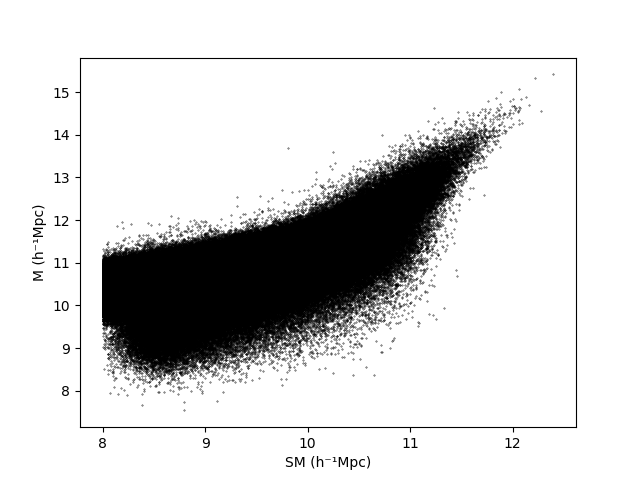

[Text(0.5, 0, 'SM (h⁻¹Mpc)'), Text(0, 0.5, 'M (h⁻¹Mpc)')]

In [33]:
%matplotlib notebook

ax = plt.subplot()

# Density plot
ax.scatter(SM, M, s=0.1, c ='black')
ax.set(xlabel='SM (h⁻¹Mpc)', ylabel='M (h⁻¹Mpc)')
#ax.set_xlim(1e8, 0.4*1e12)
#ax.set_ylim(0, 0.2*1e15)

<IPython.core.display.Javascript object>


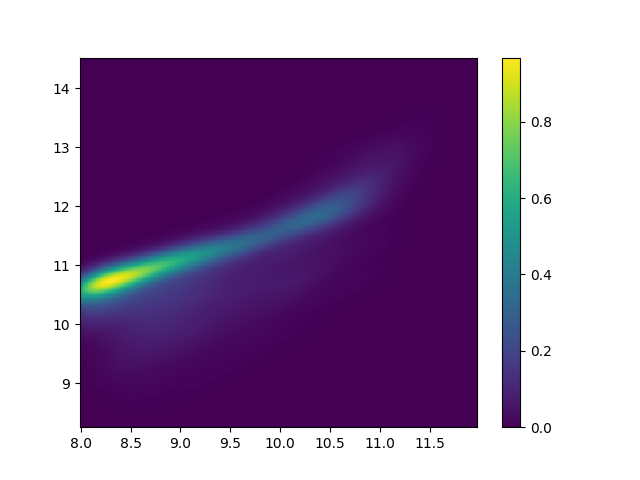

In [28]:
%matplotlib notebook

x = np.array(SM)
y = np.array(M)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.show()

# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.show()

#plt.scatter(SM, M, s=0.01, c ='white')

In [34]:
redshift.galaxies.sort(key=lambda x: x.SM)

In [40]:
def median_galaxy(gs): # cambiar a numpy 
    SM = STEP*(gs[0].SM//STEP)+STEP/2 # Medias pesadas (suma/Ngalaxies)
    
    M = 0
    if len(gs) % 2 == 0:
        M = (gs[len(gs)//2-1].M+gs[len(gs)//2].M)/2
    else:
        M = gs[len(gs)//2].M
    
    return Galaxy(M, SM, 0)

In [36]:
r = Redshift(PATHS[0], False)

curr = 0
tmp = []
for g in redshift.galaxies:
    region = g.SM//STEP
    
    if curr == region:
        tmp.append(g)
    else:
        if len(tmp):
            r.galaxies.append(median_galaxy(tmp))
        curr = region
        tmp = [g]
        
if len(tmp):
    r.galaxies.append(median_galaxy(tmp))
    
r.Ngalaxies = len(r.galaxies)

In [37]:
SM = [g.SM for g in r.galaxies]
M = [g.M for g in r.galaxies]

<IPython.core.display.Javascript object>


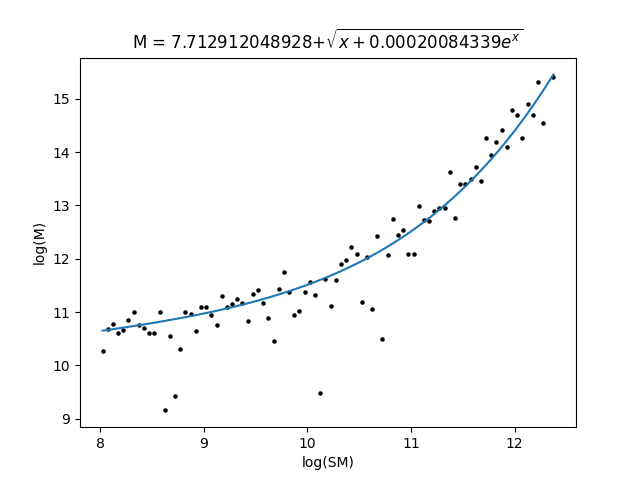

[Text(0.5, 0, 'log(SM)'), Text(0, 0.5, 'log(M)')]

In [57]:
%matplotlib notebook

ax = plt.subplot()

x = np.linspace(min(SM), max(SM), 100)
y = 7.712912048928+np.sqrt((x+np.exp((x-np.exp((np.pi-1))))))

ax.scatter(SM, M, s=5, c ='black')
ax.set_title(r"M = 7.712912048928+$\sqrt{x+0.00020084339e^{x}}$")
ax.plot(x, y)
ax.set(xlabel='log(SM)', ylabel='log(M)') # RMS Error barras
#ax.set_xlim(1e8, 0.4*1e12)
#ax.set_ylim(0, 0.2*1e14)

## Distribution

10.836922582372043


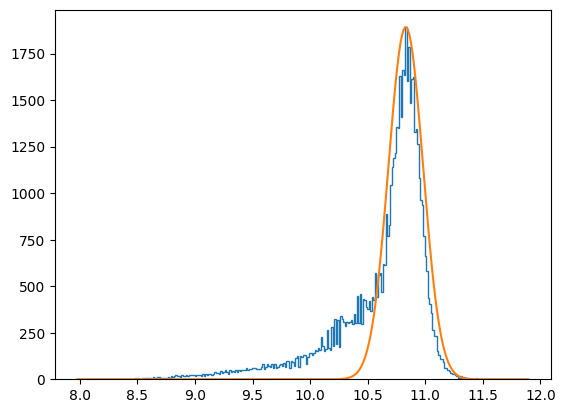

In [9]:
redshift.galaxies.sort(key=lambda x: x.SM)

distribution = []
for g in redshift.galaxies:
    if g.SM >= DISTRIBUTION_CENTER-DISTRIBUTION_WIDTH and g.SM <= DISTRIBUTION_CENTER+DISTRIBUTION_WIDTH:
        distribution.append(g.M)

distribution_counts, distribution_bins = np.histogram(distribution, DISTRIBUTION_BINS)
plt.stairs(distribution_counts, distribution_bins)

print(distribution_bins[219])

x = distribution_bins
y = -21.718190929546+(x*np.exp((x-(np.exp(np.pi)/np.pi))))
y = 1893*np.exp(-0.5*((x-10.83)/0.15)**2)

plt.plot(x, y)
plt.show()

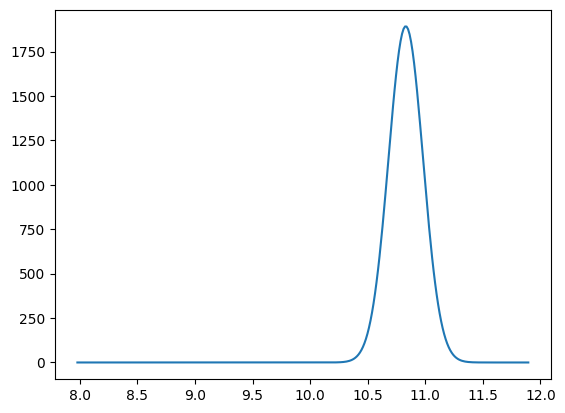

In [10]:
x = distribution_bins
y = 1893*np.exp(-0.5*((x-10.83)/0.15)**2)

plt.plot(x, y)

## PySR

In [15]:
from pysr import PySRRegressor

model = PySRRegressor(
    procs=4,
    populations=8,
    population_size=50,
    ncyclesperiteration=500, 
    niterations=500,
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 1e-6 && complexity < 10"
    ),
    timeout_in_seconds=60 * 60 * 24,
    binary_operators=["+", "*", "/", "-"],
    unary_operators=[
        "exp",
        "square"
    ],
    nested_constraints={
        "square": {"square": 1, "exp": 0},
        "exp": {"square": 1, "exp": 0},
    },
    complexity_of_operators={"/": 2, "exp": 3},
    complexity_of_constants=2,
    select_k_features=4,
    progress=True,
    weight_randomize=0.1,
    cluster_manager=None,
    precision=64,
    warm_start=True,
    turbo=True,
    julia_project=None,
    update=False,
)

In [16]:
X = np.array([[b] for b in distribution_bins])
y = 1893*np.exp(-0.5*((X[:,0]-10.83)/0.15)**2)

In [ ]:
model.fit(X, y)

Using features ['x0']


## AI-Feynman

### AI-Feynman Equation

In [14]:
with open(f"data/redshift{Z}.txt", "w") as f:
    for g in r.galaxies:
        f.write(f"{g.SM} {g.M}\n")

NameError: name 'r' is not defined

In [ ]:
aifeynman.run_aifeynman("./data/", "redshift0.txt", 60, ROOT+"aifeynman/12ops.txt", polyfit_deg=5, NN_epochs=50)

### AI-Feynman Distribution

In [55]:
with open(f"data/redshift{Z}_distribution.txt", "w") as f:
    for i in range(len(x)):
        #f.write(f"{(distribution_bins[i+1]+distribution_bins[i])/2} {distribution_counts[i]}\n")
        f.write(f"{x[i]} {y[i]}\n")

In [56]:
aifeynman.run_aifeynman("./data/", "redshift0_distribution.txt", 60, ROOT+"aifeynman/11ops.txt", polyfit_deg=3, NN_epochs=500)

Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve ./data/redshift0_distribution.txt_train
Rejection threshold.....    10.000
Bit margin..............     0.000
Number of variables.....       1
Functions used..........              +*-/><~E
 Arity            0 : a
 Arity            1 : ><~E
 Arity            2 : +*-/
Loading mystery data....
         240  rows read from file mystery.dat                                                                                                                                                                                                                                                     
Number of examples......     240
Shuffling mystery data..
 Searching for best fit...
     31.678784136938     -8.826674853246                      a               1             0.0000          7602.9082           538.9660          1889.4222             4.8446           240.0000
     21.778166282671      0.000004227685      